In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (4,3)
mpl.rcParams['figure.dpi'] = 100

lmax = 100

from getdist.gaussian_mixtures import GaussianND
from getdist import plots

2.039917004449462e-09


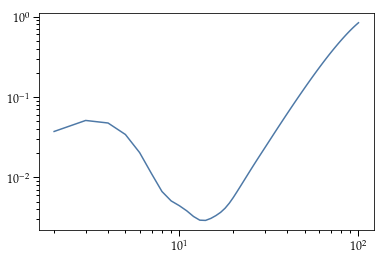

In [2]:
from classy import Class

planck_noise = 120 # uK_arcmin
class_noise = 30 # uK_arcmin
cv_noise = 0

# Define your cosmology (what is not specified will be set to CLASS default parameters)
params = {
    'output': 'tCl pCl lCl',
    'l_max_scalars': lmax,
    'lensing': 'yes',
    'A_s': 2.3e-9,
    'n_s': 0.965,
    'tau_reio':0.06}

amp = params['A_s']*np.exp(-2*params['tau_reio'])
print(amp)
cosmo = Class()
cosmo.set(params)
cosmo.compute()
cls = cosmo.lensed_cl(lmax)
#cosmo.struct_cleanup()
#cosmo.empty()
Z = cls['ell']*(cls['ell']+1)/(2*np.pi)*(cosmo.T_cmb()*1e6)**2
plt.loglog(cls['ell'][2:], cls['ee'][2:]*Z[2:])

In [3]:
from scipy.integrate import trapz, cumtrapz
def get_tau(thermo, zmax=100, xmin=2e-4):
    eta = thermo['conf. time [Mpc]']
    z = thermo['z']
    x_e = thermo['x_e']
    dtaudeta = thermo["kappa' [Mpc^-1]"]
    sigmaTan_p = dtaudeta/x_e
    integrand = -sigmaTan_p*x_e
    return trapz(integrand[(x_e>xmin) & (z<zmax)], x=eta[(x_e>xmin) & (z<zmax)])

def get_tau_z(thermo, zmax=100, xmin=2e-4):
    eta = thermo['conf. time [Mpc]']
    z = thermo['z']
    x_e = thermo['x_e']
    dtaudeta = thermo["kappa' [Mpc^-1]"]
    sigmaTan_p = dtaudeta/x_e
    integrand = -sigmaTan_p*x_e
    return z, cumtrapz(integrand, x=eta)


def get_twotau(thermo, zmax=100, xmin=2e-4):
    eta = thermo['conf. time [Mpc]']
    z = thermo['z']
    x_e = thermo['x_e']
    dtaudeta = thermo["kappa' [Mpc^-1]"]
    sigmaTan_p = dtaudeta/x_e
    integrand = -sigmaTan_p*x_e
    zre = z[np.where(x_e < 0.5)[0][0]]
    zsplit = 1+zre
    tau_lo = trapz(integrand[(x_e>xmin) & (z<zsplit)], x=eta[(x_e>xmin) & (z<zsplit)])
    tau_hi = trapz(integrand[(x_e>xmin) & (z>zsplit) & (z<zmax)], x=eta[(x_e>xmin) & (z>zsplit) & (z<zmax)])
    return zsplit, tau_lo, tau_hi


In [4]:
def twinplot(ell, Cl, axes=None, label=None, color='k', marker='.',
        linestyle=' ', ymin=None, ymax=None, alpha=1, axlabels=True, lw=None):
    if axes == None:
        ax = plt.gca()
        axes = [ax, ax.twinx()]

    axes[0].semilogx(ell, np.log10(Cl), label=label, color=color, marker=marker,
            linestyle=linestyle, alpha=alpha, lw=lw)

    if (ymin == None) & (ymax == None):
        ymin, ymax = axes[0].get_ylim()
    else:
        ymin, ymax = np.log10(ymin), np.log10(ymax)
        axes[0].set_ylim(ymin, ymax)
    values = np.arange(int(ymin), int(ymax))
    labels = 10.**values
    axes[0].set_yticks(values, minor=False)

    # If you do this, you get tick labels like $10^{-16}$.
    f = mpl.ticker.ScalarFormatter(useOffset=False, useMathText=True)
    g = lambda x,pos : "${}$".format(f._formatSciNotation('%1.10e' % 10.**x))
    axes[0].get_yaxis().set_major_formatter(mpl.ticker.FuncFormatter(g))
    # If you do this, you get tick labels like 1e-16
    #axes[0].get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

    xticks = np.array([2, 5, 10, 20, 50, 100, 200])
    axes[0].set_xticks(xticks)
    axes[0].set_xticklabels(xticks)


    l0 = np.array([], dtype='float')
    labels = np.arange(1, 10)
    for i in range(-24, 4):
        l0 = np.concatenate((l0, 10**i*labels))
    axes[0].set_yticks(np.log10(l0), minor=True)
    axes[0].set_ylim(ymin, ymax)

    base = np.array([3, 5, 10, 15])
    labels = np.array([300, 500, 1000, 1500, 3000, 5000,
        10000, 15000, 30000, 50000, int(1e5), int(1.5e5), int(3e5), int(5e5)]).astype('str')
    labels = np.concatenate(((10*base).astype('str'), labels))
    labels = np.concatenate((base.astype('str'), labels))
    labels = np.concatenate((np.round((10**-1*base),2).astype('str'), labels))
    labels = np.concatenate(((np.round(10**-2*base,2)).astype('str'), labels))

    # Convert from uKarcmin to uK^2 sr
    values = np.log10((np.pi*labels.astype('float')/180/60)**2)
    axes[1].set_yticks(values, minor=False)
    axes[1].get_yaxis().set_major_formatter(mpl.ticker.FixedFormatter(labels))


    l0 = np.array([], dtype='float')
    labels = np.arange(1, 10, 0.5)
    for i in range(-2, 6):
        l0 = np.concatenate((l0, 10**i*labels))
    axes[1].set_yticks(np.log10((np.pi*l0/180/60)**2), minor=True)
    axes[1].set_ylim(axes[0].get_ylim())

    if axlabels:
        axes[1].set_ylabel(r'$w_p^{-1/2}$ [$\mathrm{\mu K\ arcmin}$]')
        axes[0].set_xlabel(r'$\ell$')
        axes[0].set_ylabel(r'$C_\ell^\mathrm{EE}$ [$\mathrm{\mu K^2\,sr}$]')

    return axes


In [5]:
def get_spectra(zreio, x_e, history=False, spectra=False, both=False, lmax=100, therm=False):
    params['many_tanh_z'] = '3.5,' + str(zreio) +',28'
    params['many_tanh_xe'] = '-2,-1,'+str(max(x_e, 2e-4))
    params['hyper_flat_approximation_nu'] = 7000. # The higher this is, the more exact
    params['transfer_neglect_delta_k_S_t0'] = 0.0017 # The lower these are, the more exact
    params['transfer_neglect_delta_k_S_t1'] = 0.0005
    params['transfer_neglect_delta_k_S_t2'] = 0.0017
    params['transfer_neglect_delta_k_S_e'] = 0.0013
    params['delta_l_max'] = 1000 # difference between l_max in unlensed and lensed spectra

    cosmo.set(params)
    cosmo.compute()
    thermo = cosmo.get_thermodynamics()
    tau = get_tau(thermo)
    params['A_s'] = 2.3e-9*np.exp(-2*0.06)/np.exp(-2*tau)
    cosmo.set(params)
    cosmo.compute()
    if both:
        thermo = cosmo.get_thermodynamics()
        z, xe = thermo['z'], thermo['x_e']
        cls = cosmo.lensed_cl(lmax)
        ell, EE, TE = cls['ell'], cls['ee'], cls['te']
        return z, xe, ell, EE, TE
    elif therm:
        return cosmo.get_thermodynamics()
    elif spectra:
        cls = cosmo.lensed_cl(lmax)
        ell, EE, TE = cls['ell'], cls['ee'], cls['te']
        return ell, EE, TE
    elif history:
        thermo = cosmo.get_thermodynamics()
        z, xe = thermo['z'], thermo['x_e']
        return z, xe
    else:
        return

0.06050135225157331 (9.378596548280782, 0.059978604891269334, 0.0005219387491236643)
0.0626179436870837 (6.598827154017637, 0.03478496311965771, 0.027767267715846172)
2.039917004449462e-09


/etc/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:1442: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ret = ax.set_xlim(*args, **kwargs)


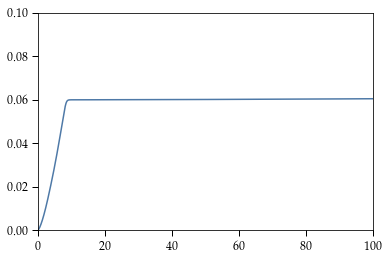

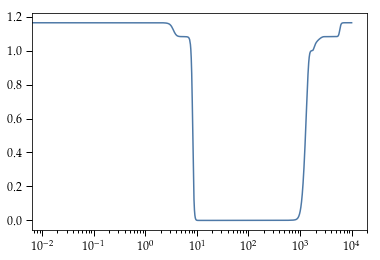

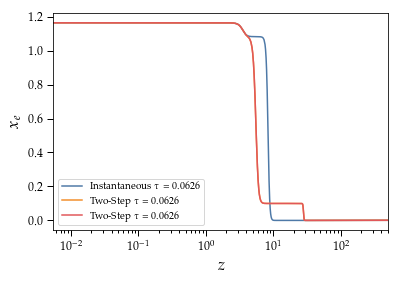

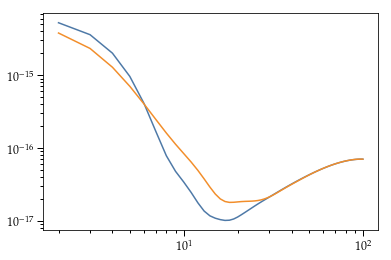

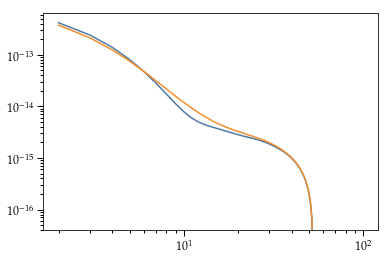

In [6]:
thermo = cosmo.get_thermodynamics()


plt.figure()
z, tau_z = get_tau_z(thermo)
plt.plot(z[1:], tau_z)
plt.ylim([0,0.1])
plt.xlim([0, 100])

plt.figure()
plt.semilogx(thermo['z'], thermo['x_e'], label=r'Instantaneous $\tau=0.0626$')
print(get_tau(thermo), get_twotau(thermo))
zsplit1, taulo, tauhi = get_twotau(thermo)

plt.figure()
plt.semilogx(thermo['z'], thermo['x_e'], label=r'Instantaneous $\tau=0.0626$')

params['reio_parametrization'] ='reio_many_tanh'

params['many_tanh_num'] = 3
params['many_tanh_z'] = '3.5,5.5,28'
params['many_tanh_xe'] = '-2,-1,0.1'
#params['many_tanh_num'] = 2
#params['many_tanh_z'] = '3.5,11.3'
#params['many_tanh_xe'] = '-2,-1'

params['many_tanh_width'] = 0.5
pars = ['tau_reio', 'binned_reio_num', 'binned_reio_z', 'binned_reio_xe', 'binned_reio_step_sharpness']
for p in pars:
    if p in params: del params[p]

cosmo.empty()
cosmo.set(params)
cosmo.compute()
thermo = cosmo.get_thermodynamics()
#plt.plot(thermo['z'], thermo['x_e'])
#plt.xlim([0,30])
plt.xlabel(r'$z$')
plt.ylabel(r'$x_e$')
print(get_tau(thermo), get_twotau(thermo))
zsplit2, taulo, tauhi = get_twotau(thermo)
amp = params['A_s']*np.exp(-2*0.06)
params['A_s'] = amp/np.exp(-2*(taulo+tauhi))
cosmo.set(params)
cosmo.compute()
thermo = cosmo.get_thermodynamics()
plt.plot(thermo['z'], thermo['x_e'], label=r'Two-Step $\tau={0}$'.format(np.round(taulo+tauhi,4)))
plt.xlim([0,500])
print(amp)
plt.legend(loc='best')


plt.plot(thermo['z'], thermo['x_e'], label=r'Two-Step $\tau={0}$'.format(np.round(taulo+tauhi,4)))
plt.xlim([0,500])
plt.legend(loc='best')
#plt.yscale('log')

plt.figure()
cls2 = cosmo.lensed_cl(lmax)
Z = cls2['ell']*(cls2['ell']+1)/(2*np.pi)*(cosmo.T_cmb()*1e6)**2
plt.loglog(cls['ell'][2:], cls['ee'][2:])   
plt.loglog(cls2['ell'][2:], cls2['ee'][2:])

plt.figure()
plt.loglog(cls['ell'][2:], cls['te'][2:])
plt.loglog(cls2['ell'][2:], cls2['te'][2:])


/etc/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log10


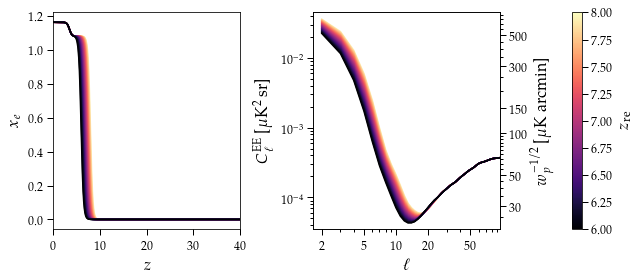

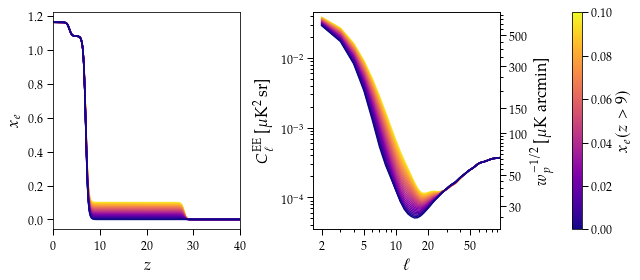

In [7]:
zs = np.linspace(6, 8, 25)
xes = np.linspace(0, 0.1, 25)
z0 = zs.mean()
xe0 = xes.mean()
xe0 = 0

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(9,4), gridspec_kw={"width_ratios":[1,1, 0.05]})
ax1 = axes[0]
ax2 = axes[1]
cax = axes[2]
axs2 = [ax2, ax2.twinx()]
taulos1 = []
tauhis1 = []
for i in range(len(zs))[::-1]:
    z, xe, ell, EE, TE = get_spectra(zs[i], xe0, both=True)
    thermo = get_spectra(zs[i], xe0, therm=True)
    _, taulo, tauhi = get_twotau(thermo, zmax=100, xmin=2e-4)
    taulos1.append(taulo)
    tauhis1.append(tauhi)
    ax1.plot(z, xe, color=plt.cm.magma(i/len(zs)))
    ax1.set_xlim([0, 40])
    ax1.set_xlabel(r'$z$')
    ax1.set_ylabel(r'$x_e$')
    twinplot(ell, (2.7e6)**2*EE, linestyle='-', marker=None, color=plt.cm.magma(i/len(zs)), axes=axs2, ymin=3.5e-5, ymax=4.5e-2)
plt.xlim(right=95)
sm = plt.cm.ScalarMappable(cmap=plt.cm.magma, norm=plt.Normalize(vmin=zs.min(), vmax=zs.max()))
sm._A = []
fig.colorbar(sm, cax=cax, label=r'$z_\mathrm{re}$')
taulos1 = taulos1[::-1]
tauhis1 = tauhis1[::-1]


plt.tight_layout()
    
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(9,4), gridspec_kw={"width_ratios":[1,1, 0.05]})
ax1 = axes[0]
ax2 = axes[1]
cax = axes[2]
axs2 = [ax2, ax2.twinx()]
taulos2 = []
tauhis2 = []
for i in range(len(zs))[::-1]:
    z, xe, ell, EE, TE = get_spectra(z0, xes[i], both=True)
    thermo = get_spectra(z0, xes[i], therm=True)
    _, taulo, tauhi = get_twotau(thermo, zmax=100, xmin=2e-4)
    taulos2.append(taulo)
    tauhis2.append(tauhi)

    ax1.plot(z, xe, color=plt.cm.plasma(i/len(zs)))
    ax1.set_xlim([0, 40])
    ax1.set_xlabel(r'$z$')
    ax1.set_ylabel(r'$x_e$')
    twinplot(ell, (2.7e6)**2*EE, linestyle='-', marker=None, color=plt.cm.plasma(i/len(zs)), axes=axs2, ymin=3.5e-5, ymax=4.5e-2)
plt.xlim(right=95)
sm = plt.cm.ScalarMappable(cmap=plt.cm.plasma, norm=plt.Normalize(vmin=xes.min(), vmax=xes.max()))
sm._A = []
fig.colorbar(sm, cax=cax, label=r'$x_e(z>9)$')
taulos2 = taulos2[::-1]
tauhis2 = tauhis2[::-1]

plt.tight_layout()


0.009271104341481387 -0.017646659521784624
0.25997114187711107 0.000491488782223699
0.05191064513984556


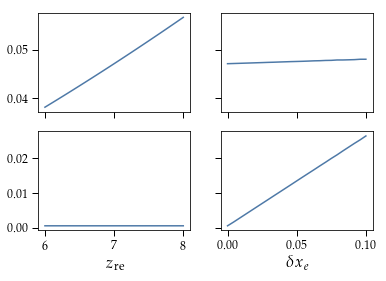

In [8]:
# taulos1, tauhis1 is where zre changes and xe stays the same.
from scipy import stats
tauhis1 = np.array(tauhis1)
taulos2 = np.array(taulos2)
# taulos2, tauhis2 is where xe changes and zre stays the same.
fig, ax = plt.subplots(2, 2, sharex='col', sharey='row')
ax[0,0].plot(zs, taulos1)
#plt.title(r'$\tau_\mathrm{lo-z}$')
#plt.subplot(222)
ax[1,0].plot(zs, tauhis1)
ax[1,0].set_xlabel(r'$z_\mathrm{re}$')
# this should have practically no effect
#plt.title(r'$\tau_\mathrm{hi-z}$')
#plt.subplot(223)
ax[0,1].plot(xes, taulos2)
# this should have practically no effect
#plt.subplot(224)
ax[1,1].plot(xes, tauhis2)
ax[1,1].set_xlabel(r'$\delta x_e$')

slope, intercept, r_value, p_value, std_err = stats.linregress(zs, taulos1)
print(slope, intercept)

slope, intercept, r_value, p_value, std_err = stats.linregress(xes, tauhis2)
print(slope, intercept)


def get_taus_simp(zre, xe):
    taulo = -0.01736288370260474 + 0.00929724716106184*zre
    tauhi = 0.000491488782223699 + 0.259971141877111*xe
    return taulo, tauhi, taulo+tauhi

dtaulodz = 0.00929724716106184
dtauhidx = 0.259971141877111

print(get_taus_simp(6, 0.05)[2])

In [9]:
def get_EE(x_e, zre, lmax=100):
    ell, Cl, TE = get_spectra(zre, x_e, lmax=lmax, spectra=True)
    return Cl

def get_EE_2D(zre, x_e, lmax=100):
    ell, Cl, TE = get_spectra(zre, x_e, lmax=lmax, spectra=True)
    return Cl

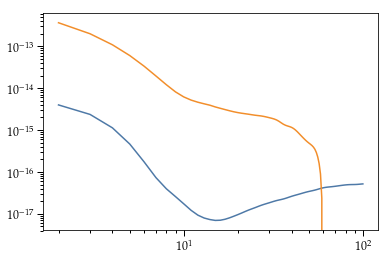

In [10]:

ell, ee, te = get_spectra(7, 0, spectra=True)
plt.loglog(ell[2:], ee[2:])
plt.loglog(ell[2:], te[2:])

/etc/anaconda3/lib/python3.6/site-packages/healpy/sphtfunc.py:395: FutureChangeWarning: The order of the input cl's will change in a future release.
Use new=True keyword to start using the new order.
See documentation of healpy.synalm.
  category=FutureChangeWarning,


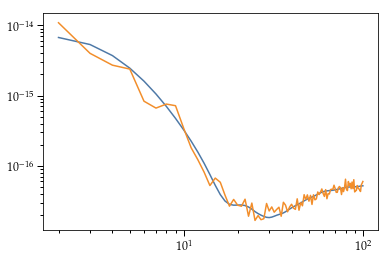

In [11]:
import healpy as hp
ell, ee, te = get_spectra(7, 0.2, spectra=True, lmax=lmax)
plt.loglog(ell[2:], ee[2:])
eehat = hp.alm2cl(hp.synalm(ee, lmax=lmax))
plt.loglog(ell[2:], eehat[2:])

/etc/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


-112.13884327463853 -112.13884327463853


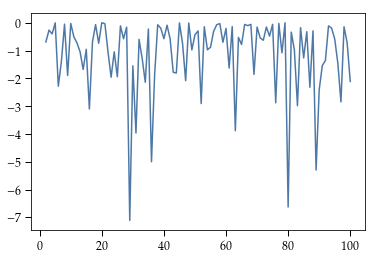

In [12]:
def lnprob_EE_ell(zre, x_e, Clhat):
    ell, Cl, TE = get_spectra(zre, x_e, lmax=len(Clhat)-1, spectra=True)
    chi2_ell = (2*ell+1)*(Clhat/Cl + np.log(Cl/Clhat)-1)
    return -chi2_ell#-chi2_exp_ell

chi2_ell = lnprob_EE_ell(7, 0.2, eehat)
plt.plot(ell[2:], chi2_ell[2:])

def lnprob(args, Clhat):
    zre, x_e = args
    if (zre < 4) | (x_e < 0) | (x_e > 0.5):
        return -np.inf
    return sum(lnprob_EE_ell(zre, x_e, Clhat)[2:])

def lnprob_2D(args, Clhat):
    zre, x_e = args
    if (zre < 4) | (x_e < 0) | (x_e > 0.5):
        return -np.inf
    return sum(lnprob_EE_ell(zre, x_e, Clhat)[2:])

def lnprob_1D(args, Clhat):
    zre = args
    x_e = 0
    if (zre < 4) | (x_e < 0) | (x_e > 0.5):
        return -np.inf
    return sum(lnprob_EE_ell(zre, x_e, Clhat)[2:])


print(sum(chi2_ell[2:]), lnprob(np.array([7, 0.2]), eehat))

/etc/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


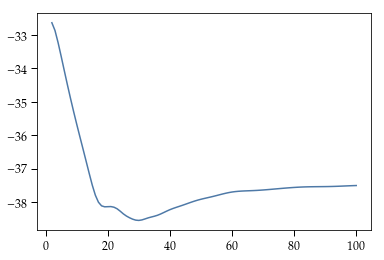

In [13]:
plt.plot(ell, np.log(ee))

In [14]:
def get_F(zre, xe, dzre=1e-2, dxre=1e-2, ell_arr=False, lmin=2, lmax=100, N_l=0):
    F = np.zeros((2,2))
    dlogCldzre = (np.log(get_EE_2D(zre+dzre, xe)+N_l) - np.log(get_EE_2D(zre, xe)+N_l))/dzre
    dlogCldxre = (np.log(get_EE_2D(zre, xe+dxre)+N_l) - np.log(get_EE_2D(zre, xe)+N_l))/dxre
    ell = np.arange(101)
    Fxx = sum(((2*ell+1)/2*dlogCldxre**2)[lmin:lmax+1])
    Fzz = sum(((2*ell+1)/2*dlogCldzre**2)[lmin:lmax+1])
    Fxz = sum(((2*ell+1)/2*dlogCldxre*dlogCldzre)[lmin:lmax+1])
    F = np.array([[Fzz,Fxz],[Fxz,Fxx]])
    if ell_arr:
        return (2*ell+1)/2*dlogCldzre**2, (2*ell+1)/2*dlogCldxre**2, (2*ell+1)/2*dlogCldxre*dlogCldzre
    else:
        return F

In [15]:
mean = np.array([7, 0.2])
F = get_F(*mean)
Finv = np.linalg.inv(F)

np.diag(np.linalg.inv(F))**0.5

/etc/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()
/etc/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in subtract
  app.launch_new_instance()
/etc/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log
/etc/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in subtract


array([0.69364173, 0.00859706])

/etc/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()
/etc/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in subtract
  app.launch_new_instance()
/etc/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log
/etc/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in subtract


[0.38721983 0.00493727]


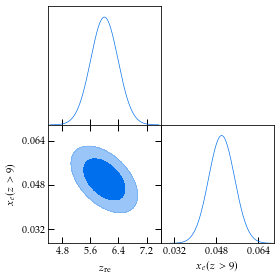

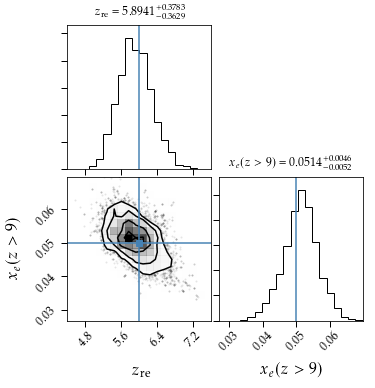

In [16]:
mean = np.array([6, 0.05])
F = get_F(*mean)
Finv = np.linalg.inv(F)
covariance = Finv
gauss=GaussianND(mean, covariance, labels=[r'$z_\mathrm{re}$', r'$x_e(z>9)$'])
g = plots.getSubplotPlotter()
g.triangle_plot(gauss, filled=True)
print(np.diag(Finv)**0.5)


fig = plt.gcf()

data = np.loadtxt('chain_5.dat')
chain = data.reshape((-1,24,3))
chain_cut = chain[100:].reshape(-1,3)
from corner import corner
ranges = [g.fig.axes[2].get_xlim(), g.fig.axes[2].get_ylim()]
fig = corner(chain_cut[:,-2:], truths=[6, 0.05], show_titles=True, title_fmt='.4f', range=ranges,
            labels=[r'$z_\mathrm{re}$', r'$x_e(z>9)$'])



Removed no burn in


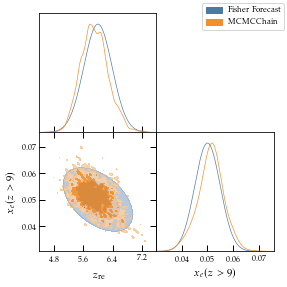

In [17]:
from getdist import MCSamples
labels = [r'$z_\mathrm{re}$', r'$x_e(z>9)$']
gauss=GaussianND(mean, covariance, names=labels, labels=labels, label='Fisher Forecast')
samples = MCSamples(samples=chain_cut[:,-2:], names=labels, labels=labels, label='MCMC Chain')
settings = plots.GetDistPlotSettings(subplot_size_inch=8)
g = plots.getSubplotPlotter(settings=settings)
g.triangle_plot([gauss, samples], filled=True, contour_colors=['C0', 'C1'])


In [18]:
    xe = 0.1
    zre = 6
    dzre = 1e-1
    dxre = 1e-2
    dlogCldxre = (np.log(get_EE(xe+dxre, zre)) - np.log(get_EE(xe, zre)))/dxre
    dlogCldzre = (np.log(get_EE(xe, zre+dzre)) - np.log(get_EE(xe, zre)))/dzre


/etc/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in log
/etc/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in subtract
/etc/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in log
/etc/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in subtract


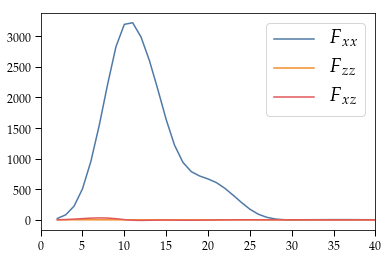

In [19]:
ell = np.arange(101)
plt.loglog(ell, (2*ell+1)/2*dlogCldxre**2, label=r'$F_{xx}$')
plt.loglog(ell, (2*ell+1)/2*dlogCldzre**2, label=r'$F_{zz}$')
plt.loglog(ell, (2*ell+1)/2*dlogCldzre*dlogCldxre, label=r'$F_{xz}$')
plt.xscale('linear')
plt.yscale('linear')
plt.xlim([0, 40])
plt.legend(loc='best', fontsize=20)

In [20]:
Fxx_l = (2*ell+1)/2*dlogCldxre**2
Fzz_l = (2*ell+1)/2*dlogCldzre**2
Fxz_l = (2*ell+1)/2*dlogCldzre*dlogCldxre

Fxx = sum(Fxx_l[2:])
Fzz = sum(Fzz_l[2:])
Fxz = sum(Fxz_l[2:])
F = np.array([[Fxx, Fxz],[Fxz,Fzz]])
print(F)
print(np.linalg.inv(F))
print(np.diag(np.linalg.inv(F))**0.5)

[[3.06583916e+04 9.11100915e+01]
 [9.11100915e+01 4.17743003e+00]]
[[ 3.48781164e-05 -7.60694580e-04]
 [-7.60694580e-04  2.55972439e-01]]
[0.00590577 0.50593719]


/etc/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:18: RuntimeWarning: divide by zero encountered in log
/etc/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:18: RuntimeWarning: invalid value encountered in subtract


[0.4930539  0.49304512 0.4771017  0.48224054 0.48582926 0.48803872
 0.48975094 0.48902876 0.49020693 0.49054484 0.49101881 0.4914215
 0.49192421 0.49224653 0.49188238 0.49062691 0.48797083 0.48607136
 0.48248335 0.47927946 0.4733538  0.46548007 0.45436706 0.43830205
 0.4161836  0.38582873 0.34545798 0.29380825 0.23174568 0.16464829]


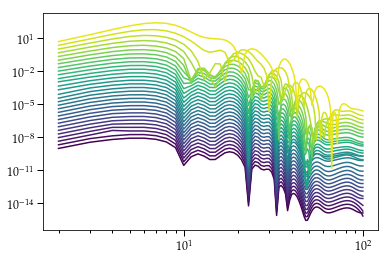

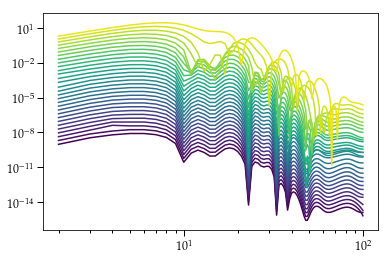

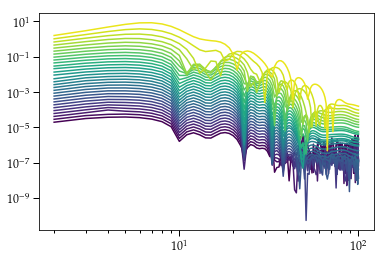

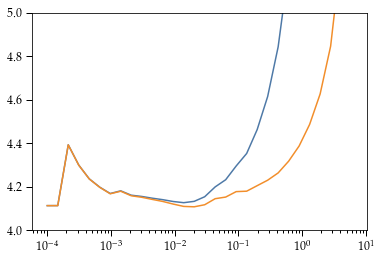

In [21]:
z = 6
lmax = 100
x_e = 0.1
ell = np.arange(lmax+1)
num = 30
Fll = np.zeros(num)
Fll2 = np.zeros(num)
dzs = np.logspace(-4, np.log10(6), num)
y = get_EE_2D(z, x_e, lmax=lmax)
den = y
for i, dz in enumerate(dzs):
    dy = get_EE_2D(z+dz, x_e, lmax=lmax)
    dCldz = (dy - y)/dz
    plt.figure(1)
    plt.loglog(ell[2:], (2*ell[2:]+1)/2*(dCldz[2:]*dz/den[2:])**2, color=plt.cm.viridis(i/len(dzs)))
    Fll[i] = sum( (2*ell[2:]+1)/2*(dCldz[2:]/den[2:])**2)
    
    dlogCldz = (np.log(dy) - np.log(y))/dz
    plt.figure(2)
    plt.loglog(ell[2:], (2*ell[2:]+1)/2*(dlogCldz[2:]*dz)**2, color=plt.cm.viridis(i/len(dzs)))
    Fll2[i] = sum( (2*ell[2:]+1)/2*dlogCldz[2:]**2)
    
    plt.figure(3)
    t = (2*ell[2:]+1)/2*(dlogCldz[2:]*dz)**2
    plt.loglog(ell[2:], (2*ell[2:]+1)/2*abs((dCldz[2:]*dz/den[2:])**2 -  (dlogCldz[2:]*dz)**2)/t,
              color=plt.cm.viridis(i/len(dzs)))

plt.figure()
plt.semilogx(dzs, Fll)
plt.semilogx(dzs, Fll2)
plt.ylim([4, 5])
print(1/Fll**0.5)

/etc/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log


1e-08


/etc/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:15: RuntimeWarning: divide by zero encountered in log
/etc/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:15: RuntimeWarning: invalid value encountered in subtract


1.6102620275609394e-08
2.592943797404667e-08
4.1753189365604005e-08
6.723357536499335e-08
1.0826367338740541e-07
1.7433288221999873e-07
2.807216203941176e-07
4.5203536563602405e-07
7.278953843983146e-07
1.1721022975334793e-06
1.8873918221350995e-06
3.0391953823131947e-06
4.893900918477499e-06
7.880462815669904e-06
1.2689610031679234e-05
2.0433597178569398e-05
3.290344562312671e-05
5.298316906283702e-05
8.531678524172815e-05
0.00013738237958832637
0.000221221629107045
0.0003562247890262444
0.0005736152510448681
0.0009236708571873865
0.0014873521072935117
0.002395026619987486
0.0038566204211634724
0.006210169418915616
0.01


/etc/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3099: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=1e-08, right=1e-08
  self.set_xlim(upper, lower, auto=None)


[0.00556278 0.00556101 0.00555114 0.00561034 0.00559284 0.00559302
 0.00558694 0.00557151 0.00554736 0.00554443 0.0055596  0.00556649
 0.00556431 0.00556265 0.00556464 0.00557069 0.00556864 0.00556968
 0.00556923 0.00556658 0.00556373 0.00556637 0.00556273 0.00555642
 0.0055452  0.00553253 0.00551313 0.00547988 0.00542719 0.00534422]


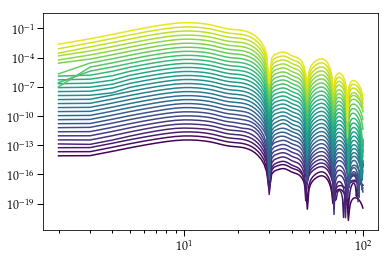

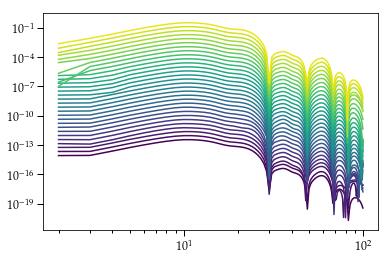

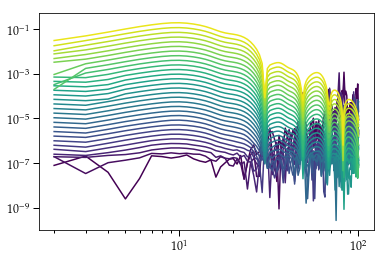

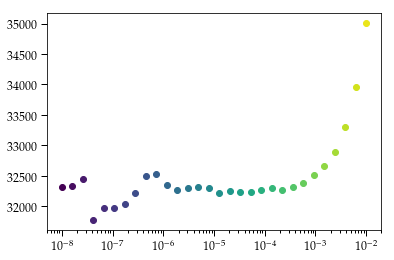

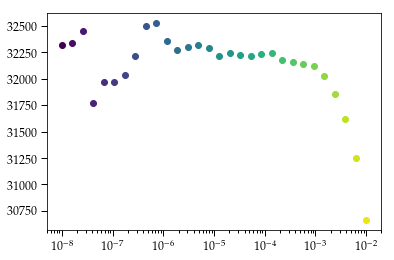

In [22]:
z = 6
lmax = 100
x_e = 0.1
ell = np.arange(lmax+1)
num = 30
Fll1 = np.zeros(num)
Fll2 = np.zeros(num)

y = get_EE_2D(z, x_e, lmax=lmax)
logy = np.log(y)
dxes = np.logspace(-8, -2, num)
for i, dxe in enumerate(dxes):
    print(dxe)
    dy = get_EE_2D(z, x_e+dxe, lmax=lmax)
    dlogCldxe = (np.log(dy) - logy)/dxe
    dCldxe = (dy - y)/dxe
    den = y
    plt.figure(1)
    plt.loglog(ell[2:], (2*ell[2:]+1)/2*(dCldxe[2:]*dxe/den[2:])**2, color=plt.cm.viridis(i/len(dxes)))
    plt.figure(2)
    plt.loglog(ell[2:], (2*ell[2:]+1)/2*(dlogCldxe[2:]*dxe)**2, color=plt.cm.viridis(i/len(dxes)))
    plt.figure(3)
    t = (2*ell[2:]+1)/2*(dlogCldxe[2:]*dxe)**2
    plt.loglog(ell[2:], (2*ell[2:]+1)/2*abs((dCldxe[2:]*dxe/den[2:])**2 -  (dlogCldxe[2:]*dxe)**2)/t,
              color=plt.cm.viridis(i/len(dxes)))
    Fll1[i] = sum( (2*ell[2:]+1)/2*(dCldxe[2:]/den[2:])**2)
    Fll2[i] = sum( (2*ell[2:]+1)/2*(dlogCldxe[2:])**2)

plt.figure()
for i in range(len(dxes)):
    plt.semilogx(dxes[i], Fll1[i], 'o', color=plt.cm.viridis(i/len(dxes)))
plt.figure()
for i in range(len(dxes)):
    plt.semilogx(dxes[i], Fll2[i], 'o', color=plt.cm.viridis(i/len(dxes)))
    
print(1/Fll1**0.5)

(0, 100)

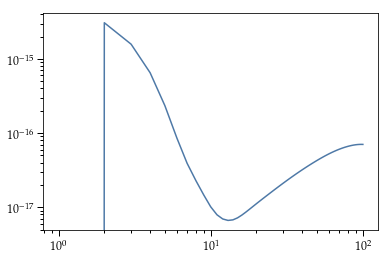

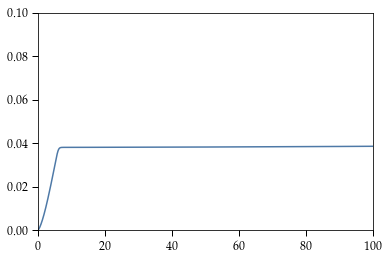

In [23]:
# How do the tau 1D chain compare to the Fisher forecast?

params = {
    'output': 'tCl pCl lCl',
    'l_max_scalars': lmax,
    'lensing': 'yes',
    'A_s': 2.3e-9,
    'n_s': 0.965,
    'z_reio':6}

cosmo = Class()
cosmo.set(params)
cosmo.compute()

def get_EE(zrei, lmax=100):
    params['z_reio'] = zrei
    cosmo.set(params)
    cosmo.compute()
    thermo = cosmo.get_thermodynamics()
    tau = get_tau(thermo)
    params['A_s'] = 2.3e-9*np.exp(-2*0.06)/np.exp(-2*tau)
    cosmo.set(params)
    cosmo.compute()
    cls = cosmo.lensed_cl(lmax)
    return cls['ee']

def get_EE_1D(zrei, lmax=100):
    params['z_reio'] = zrei
    cosmo.set(params)
    cosmo.compute()
    thermo = cosmo.get_thermodynamics()
    tau = get_tau(thermo)
    params['A_s'] = 2.3e-9*np.exp(-2*0.06)/np.exp(-2*tau)
    cosmo.set(params)
    cosmo.compute()
    cls = cosmo.lensed_cl(lmax)
    return cls['ee']
ell = np.arange(lmax+1)

plt.loglog(ell, get_EE(6, lmax=lmax))

thermo = cosmo.get_thermodynamics()


plt.figure()
z, tau_z = get_tau_z(thermo)
plt.plot(z[1:], tau_z)
plt.ylim([0,0.1])
plt.xlim([0, 100])


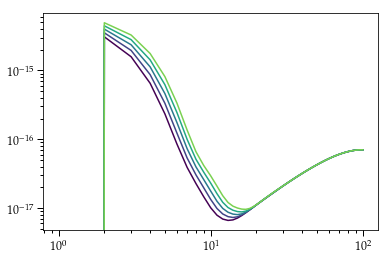

In [24]:
zreios = np.linspace(6, 8, 5)
for i, zreio in enumerate(zreios):
    plt.loglog(ell, get_EE(zreio, lmax=lmax), color=plt.cm.viridis(i/len(zreios)))

In [25]:
z = 6
dz = 1e-1
dlogCldz = (np.log(get_EE(z+dz)) - np.log(get_EE(z)))/dz


/etc/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()
/etc/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in subtract
  app.launch_new_instance()


6 0.1


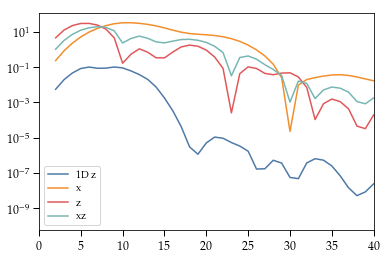

In [26]:
ell = np.arange(101)
plt.plot((2*ell+1)/2*dlogCldz**2/z**2, label='1D z')
#Fxx_l = (2*ell+1)/2*dlogCldxre**2
#Fzz_l = (2*ell+1)/2*dlogCldzre**2
#Fxz_l = (2*ell+1)/2*dlogCldzre*dlogCldxre
plt.plot(Fxx_l*x_e**2, label='x')
plt.plot(Fzz_l*z**2, label='z')
plt.plot(abs(Fxz_l)*z*x_e, label='xz')
plt.xlim([0,40])
plt.yscale('log')
plt.legend(loc='best')
print(z, x_e)

In [27]:
F_zz0 = (2*ell+1)/2*dlogCldz**2
print(1/sum(F_zz0[2:])**0.5)
print(1/sum(Fzz_l[2:])**0.5)
print(1/sum(Fxz_l[2:])**0.5)
print(1/sum(Fxx_l[2:])**0.5)

0.1944147642718362
0.4892664180840503
0.10476513055336385
0.005711173005093433


Text(0.5, 1.0, 'Constraining instantaneous reionization')

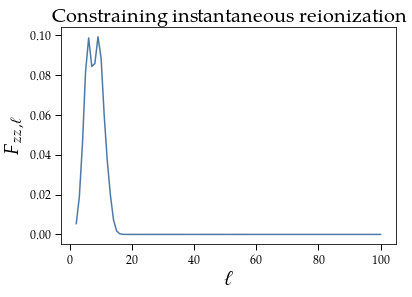

In [28]:
plt.plot((2*ell+1)/2*dlogCldz**2/z**2)
plt.xlabel(r'$\ell$', size=20)
plt.ylabel(r'$F_{zz,\ell}$', size=20)
plt.title('Constraining instantaneous reionization', size=20)

/etc/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log
/etc/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in subtract


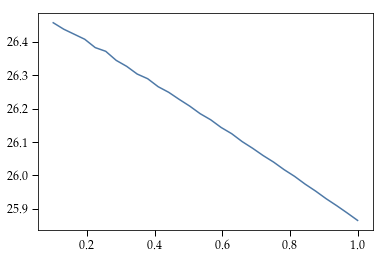

In [29]:
z = 6
lmax = 100
ell = np.arange(lmax+1)
Fll = np.zeros(num)
dzs = np.linspace(0.1, 1, num)
for i, dz in enumerate(dzs):
    dlogCldz = (np.log(get_EE(z+dz)) - np.log(get_EE(z)))/dz
    Fll[i] = sum( (2*ell[2:]+1)/2*dlogCldz[2:]**2)
#sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=0, vmax=1))
# fake up the array of the scalar mappable. Urgh...
#sm._A = []
#plt.colorbar(sm, label=r'$\mathrm dz$')
plt.plot(dzs, Fll)


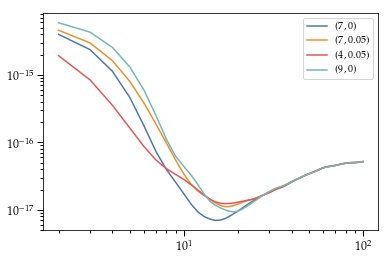

In [30]:
# Write a poor man's MCMC for the different likelihoods
params = {
    'output': 'tCl pCl lCl',
    'l_max_scalars': lmax,
    'lensing': 'yes',
    'A_s': 2.3e-9,
    'n_s': 0.965,
    'z_reio':7}
cosmo.empty()
del params['z_reio']
params['reio_parametrization'] ='reio_many_tanh'
params['many_tanh_num'] = 3
params['many_tanh_width'] = 0.5
plt.loglog(ell[2:], get_EE_2D(7, 0, lmax=ell.max())[2:], label=r'$(7, 0)$')
plt.loglog(ell[2:], get_EE_2D(7, 0.05, lmax=ell.max())[2:], label=r'$(7, 0.05)$')
plt.loglog(ell[2:], get_EE_2D(4, 0.05, lmax=ell.max())[2:], label=r'$(4, 0.05)$')
plt.loglog(ell[2:], get_EE_2D(9, 0, lmax=ell.max())[2:], label=r'$(9, 0)$')
plt.legend(loc='best')

In [31]:
#plt.plot(dzs, Fll)
print(np.array_repr(dzs))
print(np.array_repr(Fll))
# same multipoles being used? for fisher and MCMC? Do a 1D posterior
# Gry and figure out where things are numerically going wrong...
# If there's a persistent difference in the 1D versus Fisher... that's good to keep in mind.
# Look at the inferred Fisher matrix as well as those plots...

array([0.1       , 0.13103448, 0.16206897, 0.19310345, 0.22413793,
       0.25517241, 0.2862069 , 0.31724138, 0.34827586, 0.37931034,
       0.41034483, 0.44137931, 0.47241379, 0.50344828, 0.53448276,
       0.56551724, 0.59655172, 0.62758621, 0.65862069, 0.68965517,
       0.72068966, 0.75172414, 0.78275862, 0.8137931 , 0.84482759,
       0.87586207, 0.90689655, 0.93793103, 0.96896552, 1.        ])
array([26.45705583, 26.43773099, 26.42266663, 26.40762207, 26.38263337,
       26.37155948, 26.34436008, 26.32643386, 26.30344488, 26.28940239,
       26.26547482, 26.24876947, 26.22760443, 26.20750862, 26.18471303,
       26.16652002, 26.14338336, 26.12487546, 26.10117247, 26.0811028 ,
       26.05931122, 26.03967985, 26.01705464, 25.99694361, 25.97379182,
       25.95292864, 25.93015529, 25.9094448 , 25.88763181, 25.8650967 ])


In [32]:

def lnprob_2D(args, Clhat):
    zre, x_e = args
    if (zre < 4) | (x_e < 0) | (x_e > 0.5):
        return -np.inf
    return sum(lnprob_EE_ell(zre, x_e, Clhat)[2:])

def lnprob_1D(args, Clhat):
    zre = args
    x_e = 0
    if (zre < 4) | (x_e < 0) | (x_e > 0.5):
        return -np.inf
    return sum(lnprob_EE_ell(zre, x_e, Clhat)[2:])

print(lnprob_2D(np.array([7, 0]), eehat[:lmax+1]))
print(lnprob_1D(7, eehat[:lmax+1]))

/etc/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


-2751.517754698411
-2751.517754698411


/etc/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


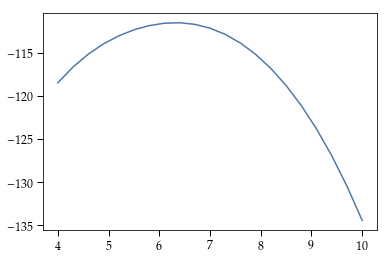

In [33]:
z = np.linspace(4, 10, 21)
lnP = np.zeros_like(z)
for i in range(len(z)):
    lnP[i] = lnprob_2D(np.array([z[i],0.2]), eehat[:lmax+1])
plt.plot(z, lnP)

6.284862339920869 0.6120532549354454


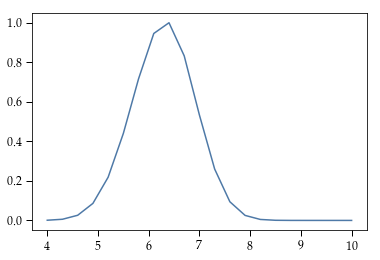

In [34]:
L = np.exp(lnP-lnP.max())
zbar = sum(z*L)/sum(L)
z2 = sum(z**2*L)/sum(L)
sd = (z2 - zbar**2)**0.5
print(zbar, sd)
plt.plot(z, L)

/etc/anaconda3/lib/python3.6/site-packages/healpy/sphtfunc.py:395: FutureChangeWarning: The order of the input cl's will change in a future release.
Use new=True keyword to start using the new order.
See documentation of healpy.synalm.
  category=FutureChangeWarning,


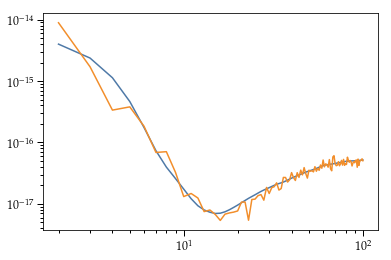

In [35]:
ell, ee, te = get_spectra(7, 0, spectra=True, lmax=lmax)
plt.loglog(ell[2:], ee[2:])
eehat = hp.alm2cl(hp.synalm(ee, lmax=lmax))
plt.loglog(ell[2:], eehat[2:])

/etc/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


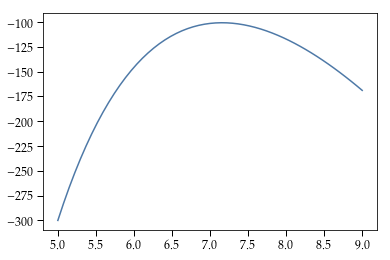

In [36]:
z = np.linspace(5, 9, 55)
lnP = np.zeros_like(z)
for i in range(len(z)):
    lnP[i] = lnprob_2D(np.array([z[i],0]), eehat[:lmax+1])
plt.plot(z, lnP)

7.16232957581852 0.13716262917456298


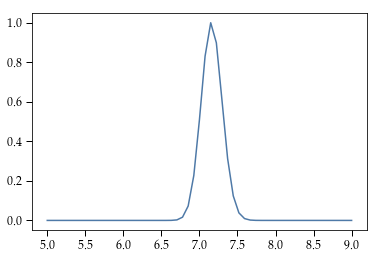

In [37]:
L = np.exp(lnP-lnP.max())
zbar = sum(z*L)/sum(L)
z2 = sum(z**2*L)/sum(L)
sd = (z2 - zbar**2)**0.5
print(zbar, sd)
plt.plot(z, L)

In [38]:
cosmo.struct_cleanup()
cosmo.empty()


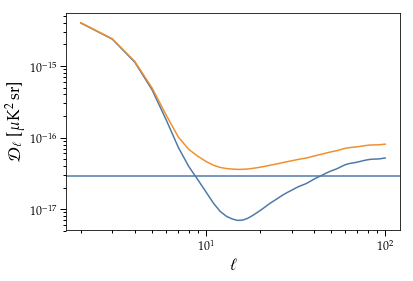

In [39]:
'''
def get_F(zre, xe, dzre = 0.5, dxre = 1e-2, N_l = 0):
    F = np.zeros((2,2))
    dlogCldxre = (np.log(get_EE_2D(zre, xe+dxre)+N_l) - np.log(get_EE_2D(zre, xe)+N_l))/dxre
    dlogCldzre = (np.log(get_EE_2D(zre+zre, xe)+N_l) - np.log(get_EE_2D(zre, xe)+N_l))/dzre
    ell = np.arange(101)
    Fxx = sum(((2*ell+1)/2*dlogCldxre**2)[2:])
    Fzz = sum(((2*ell+1)/2*dlogCldzre**2)[2:])
    Fxz = sum(((2*ell+1)/2*dlogCldxre*dlogCldzre)[2:])
    F = np.array([[Fzz,Fxz],[Fxz,Fxx]])
    return F
'''
plt.loglog(ell[2:], get_EE_2D(7, 0)[2:])
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\mathcal D_\ell$ [$\mathrm{\mu K^2\,sr}$]')

wp = 50 # uK-arcmin
N_l = (wp*np.pi/180/60)**2/((2.7e6)**2)
plt.loglog(ell[2:], get_EE_2D(7, 0)[2:] + N_l)
plt.axhline(N_l)

/etc/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()
/etc/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in subtract
  app.launch_new_instance()
/etc/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log
/etc/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in subtract


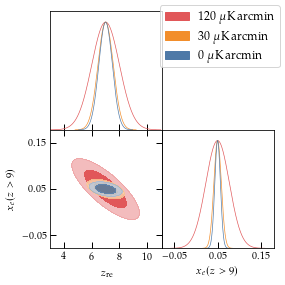

In [40]:
wps = np.arange(0, 110, 20)
wps = np.array([cv_noise, class_noise, planck_noise])
F = []

for wp in wps:
    F.append(get_F(7, 0.1, N_l=(wp*np.pi/180/60)**2/((2.7e6)**2)))

gausses = []
mean = np.array([7, 0.05])
for i in range(len(F)):
    cov = np.linalg.inv(F[i])
    gauss = GaussianND(mean, cov, labels=labels, label=r'${0}\ \mathrm{{\mu K\,arcmin}}$'.format(wps[i]))
    gausses.append(gauss)

g = plots.getSubplotPlotter()
g.triangle_plot(gausses[::-1], filled=True, colors=['C2', 'C1', 'C0'], contour_colors=['C2','C1','C0'])
plt.savefig('contours.png', dpi=300)

/etc/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()
/etc/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in subtract
  app.launch_new_instance()
/etc/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log
/etc/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in subtract


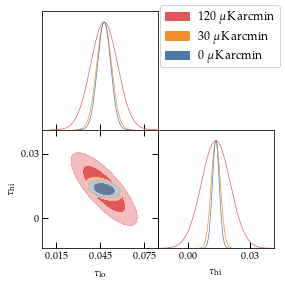

In [41]:
wps = np.arange(0, 110, 20)
wps = np.array([cv_noise, class_noise, planck_noise])
F = []

TransMat = np.array([[1/dtaulodz**2, 1/dtaulodz/dtauhidx],
                     [1/dtaulodz/dtauhidx, 1/dtauhidx**2]])

for wp in wps:
    F.append(get_F(7, 0.1, N_l=(wp*np.pi/180/60)**2/((2.7e6)**2)))

gausses = []
mean = np.array([7, 0.05])
taulo, tauhi, tautot = get_taus_simp(7, 0.05)
mean = np.array([taulo, tauhi])
for i in range(len(F)):
    cov = np.linalg.inv(F[i]*TransMat)
    gauss = GaussianND(mean, cov, labels=[r'$\tau_\mathrm{lo}$', r'$\tau_\mathrm{hi}$'], 
                                          label=r'${0}\ \mathrm{{\mu K\,arcmin}}$'.format(wps[i]))
    gausses.append(gauss)

g = plots.getSubplotPlotter()
g.triangle_plot(gausses[::-1], filled=True, colors=['C2', 'C1', 'C0'], contour_colors=['C2','C1','C0'])
plt.savefig('contours.png', dpi=300)

/etc/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()
/etc/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in subtract
  app.launch_new_instance()
/etc/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log
/etc/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in subtract


0.49285947471590547
0.49285947471590547 0.005711173005093433
4.116743233366305 4.116743233366305


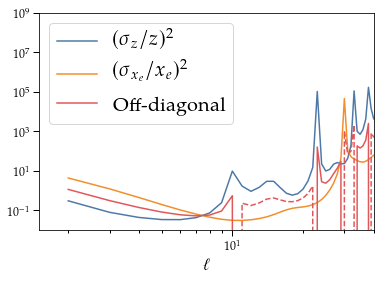

In [42]:
F_zzl, F_xxl, F_xzl = get_F(6, 0.1, ell_arr=True)

sigma_zl = 1/F_zzl**0.5
sigma_xl = 1/F_xxl**0.5
rho_xzl = 1/F_xzl
plt.plot(ell[2:], (sigma_zl[2:]/6)**2, label=r'$(\sigma_z/z)^2$')
plt.plot(ell[2:], (sigma_xl[2:]/0.1)**2, label=r'$(\sigma_{x_e}/{x_e})^2$')
plt.plot(ell[2:], rho_xzl[2:]/6/0.1, label='Off-diagonal')
plt.plot(ell[2:], -rho_xzl[2:]/6/0.1, 'C2--')

plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'$\ell$')
plt.legend(loc='best', fontsize=20)
plt.xlim([1.5, 40])
#plt.ylim([0.1, 205])
print(sum(1/sigma_zl[2:]**2)**-0.5)

F = get_F(6, 0.1)
print(1/F[0,0]**0.5, 1/F[1,1]**0.5)
print(sum(F_zzl[2:]), F[0,0])


(2, 2, 101)
[[ 1.04890158e+12 -1.35034160e+09]
 [-1.35034160e+09  8.26049639e+06]]
[[ 2.59006020e-01 -7.48186999e-04]
 [-7.48186999e-04  3.47787742e-05]]


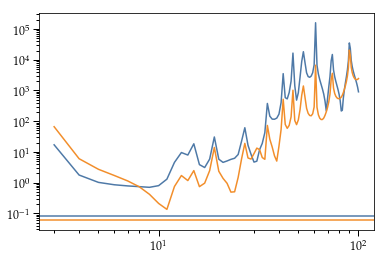

In [43]:
F_l = np.array([[F_zzl, F_xzl], [F_xzl, F_xxl]])
print(F_l.shape)
Finv_l = []
for i in range(len(ell)-1):
    Finv_l.append(np.linalg.inv(F_l[:,:,i]+F_l[:,:,i+1]))
Finv_l = np.array(Finv_l)

plt.plot(ell[3:], Finv_l[2:,0,0]**0.5/6)
plt.plot(ell[3:], Finv_l[2:,1,1]**0.5/0.1)

plt.yscale('log')
plt.xscale('log')
Finv_l[2]

print(np.sum(Finv_l[2:], axis=0))
print(np.linalg.inv(F))
Finv = np.linalg.inv(F)
plt.axhline(Finv[0,0]**0.5/6, color='C0')
plt.axhline(Finv[1,1]**0.5/0.1, color='C1')


In [44]:
print(np.linalg.inv(get_F(6,0.1, lmax=10)))
print(np.linalg.inv(get_F(6,0.1, lmin=5, lmax=15)))

/etc/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()
/etc/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in subtract
  app.launch_new_instance()
/etc/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log
/etc/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in subtract


[[ 5.15400348e-01 -6.60753983e-03]
 [-6.60753983e-03  1.71182490e-04]]
[[ 4.07366608e-01 -1.66393197e-03]
 [-1.66393197e-03  4.87776689e-05]]


0.49285947471590547 7.082628564358301e-05


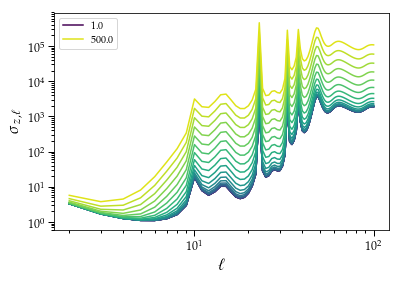

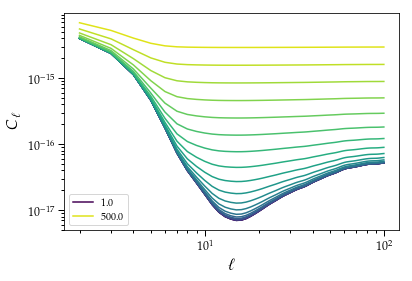

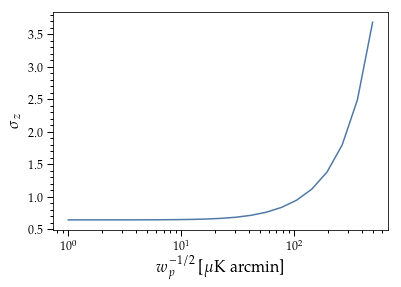

In [45]:
# It's in F_zz,l.
sigma_z = np.sqrt(1/sum(F_zzl[2:]))
sigma_zl = np.sqrt(1/F_zzl)
print(sigma_z, 1/sum(sigma_zl[2:]**2)**0.5)

wp = 50 # uK-arcmin
N_l = (wp*np.pi/180/60)**2/((2.7e6)**2)
C_l =  get_EE_2D(7, 0)[2:]

plt.figure()
sigma_zs = []
wps = np.logspace(0, 2+np.log10(5), 21)
wps[-1] = 500
for i, wp in enumerate(wps):
    N_l = (wp*np.pi/180/60)**2/((2.7e6)**2)
    if (i == 0) | (i == len(wps)-1):
        plt.figure(1)
        plt.plot(ell[2:], sigma_zl[2:]*(1+N_l/C_l), label=wp, color=plt.cm.viridis(i/len(wps)))
        plt.figure(2)
        plt.plot(ell[2:], C_l+N_l, label=wp, color=plt.cm.viridis(i/len(wps)))
    else:
        plt.figure(1)
        plt.plot(ell[2:], sigma_zl[2:]*(1+N_l/C_l), color=plt.cm.viridis(i/len(wps)))
        plt.figure(2)
        plt.plot(ell[2:], C_l+N_l, color=plt.cm.viridis(i/len(wps)))


    sigma_zs.append( sum(1/(sigma_zl[2:]**2*(1+N_l/C_l))**2)**-0.5  )
plt.figure(1)
plt.legend(loc='best')
plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\sigma_{z,\ell}$')
plt.savefig('sigmaz_ell.png', bbox_inches='tight', dpi=300)
plt.figure(2)
plt.legend(loc='best')
plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_{\ell}$')

# Right, it's the "as a function of noise" thing.
plt.figure()
plt.plot(wps, sigma_zs)
plt.xscale('log')
plt.xlabel(r'$w_p^{-1/2}$ [$\mathrm{\mu K\ arcmin}$]')
plt.ylabel(r'$\sigma_z$')
plt.minorticks_on()
plt.savefig('sigmaz.png', bbox_inches='tight', dpi=300)

0.005711173005093433 0.0005670594430498119


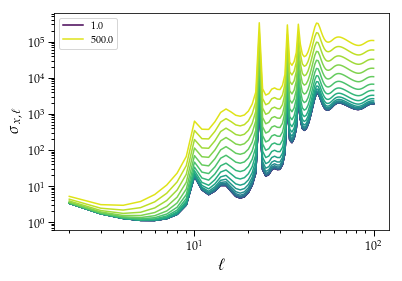

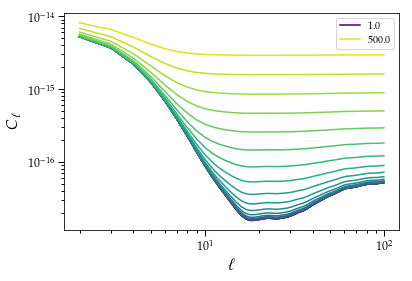

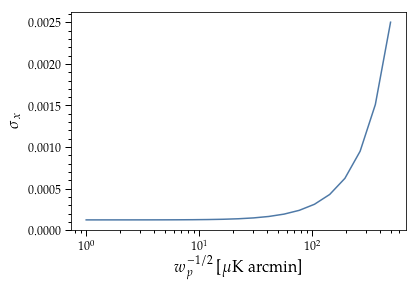

In [46]:
# It's in F_zz,l.
sigma_x = np.sqrt(1/sum(F_xxl[2:]))
sigma_xl = np.sqrt(1/F_xxl)
print(sigma_x, 1/sum(sigma_xl[2:]**2)**0.5)

wp = 50 # uK-arcmin
N_l = (wp*np.pi/180/60)**2/((2.7e6)**2)
C_l =  get_EE_2D(7, 0.1)[2:]

plt.figure()
sigma_xs = []
wps = np.logspace(0, 2+np.log10(5), 21)
wps[-1] = 500
for i, wp in enumerate(wps):
    N_l = (wp*np.pi/180/60)**2/((2.7e6)**2)
    if (i == 0) | (i == len(wps)-1):
        plt.figure(1)
        plt.plot(ell[2:], sigma_zl[2:]*(1+N_l/C_l), label=wp, color=plt.cm.viridis(i/len(wps)))
        plt.figure(2)
        plt.plot(ell[2:], C_l+N_l, label=wp, color=plt.cm.viridis(i/len(wps)))
    else:
        plt.figure(1)
        plt.plot(ell[2:], sigma_zl[2:]*(1+N_l/C_l), color=plt.cm.viridis(i/len(wps)))
        plt.figure(2)
        plt.plot(ell[2:], C_l+N_l, color=plt.cm.viridis(i/len(wps)))
    sigma_xs.append( sum(1/(sigma_xl[2:]**2*(1+N_l/C_l))**2)**-0.5  )
plt.figure(1)
plt.legend(loc='best')
plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\sigma_{x,\ell}$')
plt.savefig('sigmax_ell.png', bbox_inches='tight', dpi=300)

plt.figure(2)
plt.legend(loc='best')
plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_\ell$')


# Right, it's the "as a function of noise" thing.
plt.figure()
plt.plot(wps, sigma_xs)
plt.xscale('log')
plt.xlabel(r'$w_p^{-1/2}$ [$\mathrm{\mu K\ arcmin}$]')
plt.ylabel(r'$\sigma_x$')
plt.minorticks_on()
plt.savefig('sigmax.png', bbox_inches='tight', dpi=300)

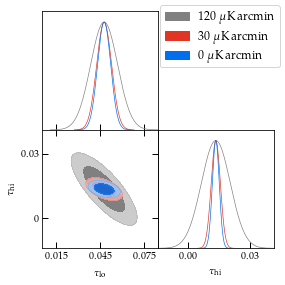

In [47]:
#settings = plots.GetDistPlotSettings(fig_width_inch=8)
g = plots.getSubplotPlotter()
g.triangle_plot(gausses[::-1], filled=True)
plt.savefig('multinoise_corner.png', bbox_inches='tight', dpi=300)

In [48]:
# use the values in the d\ln L/d\theta as a function of d\theta...
# Worth looking at the C_ls, the finite differences, asking what happens at 2e-6.


# Imagine a beam that's gonna kick up as ell increases with the beam scale...

# It would be nice to show C_ell and N_ell on the same axes, but you are starting to lose the info.


# Let's do an outline next, see what we coudl do ehre, is there something missing, etc.?